# 1. Introduction: Business Goal & Problem Definition

This projects goal is developing a deep learning model able to identify American Sign photos, so in the future we can automatically identify those signs and help deaf people communicate. I´m using a Kaggle dataset containing 2515 photos showing all digits from 0 to 9 and all alphabet letters from a to z.

# 2. Importing Basic Libraries

In [1]:
import io
import openpyxl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras

# 3. Data Collection

In [2]:
#Copying current content to new editable directory

!cp -r "../input/asl-dataset/asl_dataset/" "/kaggle/working/"

#Selecting dataset directory

ds_asl_dir = "/kaggle/working/asl_dataset/asl_dataset"

#Generating a dataset

asl_ds = tf.keras.preprocessing.image_dataset_from_directory(ds_asl_dir)

Found 2515 files belonging to 36 classes.


# 4. Data Preliminary Exploration

In [3]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "none"

#Listing directory. You can find the class names in the class_names attribute on these datasets. These correspond to the directory names in alphabetical order.

!ls "/kaggle/working/asl_dataset/asl_dataset"

#Showing index + class

pd.DataFrame(asl_ds.class_names)

0  2  4  6  8  a  c  e	g  i  k  m  o  q  s  u	w  y
1  3  5  7  9  b  d  f	h  j  l  n  p  r  t  v	x  z


,0
0,0
1,1
2,2
3,3
4,4
5,5
6,6
7,7
8,8
9,9


In [4]:
#Checking images and labels shapes (amount of images, height, width, color channels)

for image_batch, labels_batch in asl_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 256, 256, 3)
(32,)


In [5]:
#Displaying some picture´s size

from PIL import Image
img =  Image.open("/kaggle/working/asl_dataset/asl_dataset/0/hand1_0_bot_seg_1_cropped.jpeg")
width, height = img.size
print(f"Image sample with width={width} and height={height}.")

Image sample with width=400 and height=400.


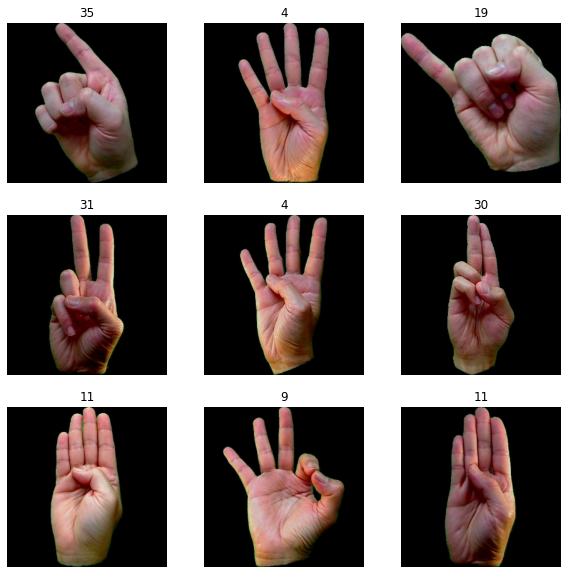

In [6]:
#Displaying image samples

plt.figure(figsize=(10, 10))
for images, labels in asl_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

# 5. Data Preparation

In [7]:
#Defining parameters for the loader

batch_size = 32
img_height = 64
img_width = 64

#Filtering out corrupted images

import os
num_skipped = 0
for folder_name in ("0","1","2","3","4","5","6","7","8","9","a","b","c","d","e","f","g","h","i","j","k","l","m","n","o"
                    ,"p","q","r","s","t","u","v","w","x","y","z"):
    folder_path = os.path.join(ds_asl_dir, folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()
        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)
print("Deleted %d images" % num_skipped)

#Augmenting the images

from keras.preprocessing.image import ImageDataGenerator
data_augmentation = ImageDataGenerator(rotation_range=15, rescale=1/255, zoom_range=0.1, horizontal_flip=True,
                                       width_shift_range=0.1, height_shift_range=0.1, validation_split=0.2)

#Setting train/test split

asl_train_ds = data_augmentation.flow_from_directory(directory=ds_asl_dir, target_size=(img_height, img_width),
                                                     class_mode="categorical", batch_size=batch_size, subset="training")
asl_test_ds = data_augmentation.flow_from_directory(directory=ds_asl_dir, target_size=(img_height, img_width),
                                                    class_mode="categorical", batch_size=batch_size, subset="validation")

Deleted 0 images
Found 2012 images belonging to 36 classes.
Found 503 images belonging to 36 classes.


# 6. Data Modelling

In [8]:
from keras.layers import Conv2D,MaxPool2D,Dropout,Flatten,Dense

#Checking if the data format i.e the RGB channel is coming first or last so, whatever it may be, model will check first and then input shape will be feeded accordingly.

from keras import backend as K
if K.image_data_format() == "channels_first":
    input_shape = (3, img_height, img_width)
else:
    input_shape = (img_height, img_width, 3)

#Creating a model

model_dl = keras.Sequential()
model_dl.add(Conv2D(16,(3,3),activation="relu",input_shape=(input_shape)))
model_dl.add(MaxPool2D(2,2))
model_dl.add(Dropout(0.2))
model_dl.add(Conv2D(32,(3,3),activation="relu"))
model_dl.add(MaxPool2D(2,2))
model_dl.add(Dropout(0.2))
model_dl.add(Conv2D(64,(3,3),activation="relu"))
model_dl.add(MaxPool2D(2,2))
model_dl.add(Dropout(0.2))
model_dl.add(Flatten())
model_dl.add(Dense(128,activation="relu"))
model_dl.add(Dropout(0.2))
model_dl.add(Dense(36,activation="softmax"))

# 7. Deep Learning Algorithm Implementation & Assessment

In [9]:
#Compiling the neural network

model_dl.compile(optimizer="Adam", loss="categorical_crossentropy", metrics=["accuracy"])

#Fitting to the model

from keras.callbacks import EarlyStopping,ReduceLROnPlateau #Import callback functions
earlystop=EarlyStopping(patience=10) #Monitor the performance. If it dips, then stop training
learning_rate_reduce=ReduceLROnPlateau(monitor="val_acc",min_lr=0.001) #Change learning rate if not performing good enough
callbacks=[earlystop,learning_rate_reduce]

model_dl.fit(asl_train_ds, validation_data=asl_test_ds, callbacks=callbacks, epochs=40)

Epoch 1/40
63/63 [==============================] - 11s 177ms/step - loss: 3.5257 - accuracy: 0.0512 - val_loss: 3.2177 - val_accuracy: 0.1054
Epoch 2/40
63/63 [==============================] - 11s 177ms/step - loss: 2.8732 - accuracy: 0.1536 - val_loss: 2.4523 - val_accuracy: 0.3260
Epoch 3/40
63/63 [==============================] - 11s 176ms/step - loss: 2.3368 - accuracy: 0.2684 - val_loss: 2.0012 - val_accuracy: 0.4056
Epoch 4/40
63/63 [==============================] - 11s 178ms/step - loss: 1.9485 - accuracy: 0.3663 - val_loss: 1.5952 - val_accuracy: 0.5169
Epoch 5/40
63/63 [==============================] - 11s 179ms/step - loss: 1.6888 - accuracy: 0.4225 - val_loss: 1.4209 - val_accuracy: 0.5726
Epoch 6/40
63/63 [==============================] - 11s 175ms/step - loss: 1.5322 - accuracy: 0.4597 - val_loss: 1.3235 - val_accuracy: 0.5805
Epoch 7/40
63/63 [==============================] - 11s 175ms/step - loss: 1.3951 - accuracy: 0.5164 - val_loss: 1.1378 - val_accuracy: 0.6322

In [10]:
#Saving the model

model_dl.save("model_dl.h5")

#Loading themodel

model_dl = keras.models.load_model("model_dl.h5") #look for local saved file

# 8. Model Deployment

In [11]:
#We´ll use any image sample from the Kaggle dataset to test it 

from keras.preprocessing import image

#Creating a dictionary to map each of the indexes to the corresponding number or letter

dict = {0:"0",1:"1",2:"2",3:"3",4:"4",5:"5",6:"6",7:"7",8:"8",9:"9",10:"a",11:"b",12:"c",13:"d",14:"e",15:"f",16:"g",
        17:"h",18:"i",19:"j",20:"k",21:"l",22:"m",23:"n",24:"o",25:"p",26:"q",27:"r",28:"s",29:"t",30:"u",31:"v",32:"w",
        33:"x",34:"y",35:"z"}

#Predicting images

img = image.load_img("/kaggle/working/asl_dataset/asl_dataset/a/hand1_a_bot_seg_1_cropped.jpeg", target_size=(img_width, img_height))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)

image = np.vstack([x])
classes = model_dl.predict_classes(image, batch_size=batch_size)
probabilities = model_dl.predict_proba(image, batch_size=batch_size)
probabilities_formatted = list(map("{:.2f}%".format, probabilities[0]*100))

print(classes) #displaying matrix prediction position

print(f'The predicted image corresponds to "{dict[classes.item()]}" with {probabilities_formatted[classes.item()]} probability.') #displaying matrix prediction position name (number or letter)

[10]
The predicted image corresponds to "a" with 100.00% probability.


# 9. Conclusions
We were able to develop a neural netork model with 83% accuracy when identifying pictures of the American Sign Language, what hopefully could be further developed to help on communication for the hearing impaired communities.